In [1]:
# Import the modules
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report
# Import the train_test_learn module
from sklearn.model_selection import train_test_split
# Import the LogisticRegression module from SKLearn
from sklearn.linear_model import LinearRegression
# pip install geopy
import geopy

In [8]:
# Seattle Housing Data Analysis
#Read in the csv file
df_seattle_sales = pd.read_csv("Resources/kingcounty/seattle_sales_cleaned_data.csv")

df_seattle_sales.head()



,id,sale_date,sale_price,latitude,longitude,city,zoning,land_val,imp_val,year_built,...,noise_traffic,view_rainier,view_olympics,view_cascades,view_territorial,view_skyline,view_sound,view_lakewash,view_otherwater,year
0,0,1/2/2018,665000,47.559358,-122.317370,SEATTLE,SF 5000,41000,122000,1920,...,0,0,0,0,0,0,0,0,0,2018
1,1,1/9/2018,499000,47.524993,-122.316475,SEATTLE,SF 5000,29000,55000,1907,...,0,0,0,0,0,0,0,0,0,2018
2,2,2/14/2018,675000,47.624203,-122.300762,SEATTLE,SF 5000,97000,132000,1908,...,0,0,0,2,0,0,0,0,0,2018
3,3,2/13/2018,1150000,47.721276,-122.335857,SEATTLE,SF 7200,440000,221000,1920,...,2,0,0,0,0,0,0,0,4,2018
4,4,2/14/2018,705000,47.666210,-122.324618,SEATTLE,SF 5000,81000,72000,1918,...,0,0,0,0,0,0,0,0,0,2018


In [9]:
# drop id column 
df_seattle_sales = df_seattle_sales.drop(columns=['id'])

# use pandas to create index
df_seattle_sales.reset_index(drop=True)
df_seattle_sales.head()

,sale_date,sale_price,latitude,longitude,city,zoning,land_val,imp_val,year_built,sqft_lot,...,noise_traffic,view_rainier,view_olympics,view_cascades,view_territorial,view_skyline,view_sound,view_lakewash,view_otherwater,year
0,1/2/2018,665000,47.559358,-122.317370,SEATTLE,SF 5000,41000,122000,1920,2525,...,0,0,0,0,0,0,0,0,0,2018
1,1/9/2018,499000,47.524993,-122.316475,SEATTLE,SF 5000,29000,55000,1907,6000,...,0,0,0,0,0,0,0,0,0,2018
2,2/14/2018,675000,47.624203,-122.300762,SEATTLE,SF 5000,97000,132000,1908,5286,...,0,0,0,2,0,0,0,0,0,2018
3,2/13/2018,1150000,47.721276,-122.335857,SEATTLE,SF 7200,440000,221000,1920,47916,...,2,0,0,0,0,0,0,0,4,2018
4,2/14/2018,705000,47.666210,-122.324618,SEATTLE,SF 5000,81000,72000,1918,3825,...,0,0,0,0,0,0,0,0,0,2018


In [10]:
#list column names for df_seattle_sales

df_seattle_sales.columns

Index(['sale_date', 'sale_price', 'latitude', 'longitude', 'city', 'zoning',
       'land_val', 'imp_val', 'year_built', 'sqft_lot', 'sqft', 'grade',
       'fbsmt_grade', 'home_condition', 'stories', 'beds', 'bath_full',
       'bath_3qtr', 'bath_half', 'garb_sqft', 'gara_sqft', 'wfnt', 'golf',
       'greenbelt', 'noise_traffic', 'view_rainier', 'view_olympics',
       'view_cascades', 'view_territorial', 'view_skyline', 'view_sound',
       'view_lakewash', 'view_otherwater', 'year'],
      dtype='object')

<Axes: >

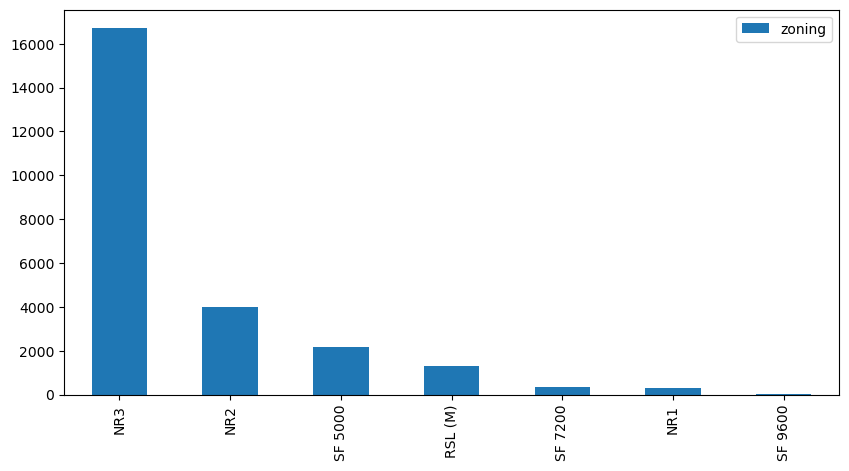

In [11]:
# Look at zoning value counts for seattle sales data
# Zoning codes in King county control the types of housing that can be built on a given plot of land.

zoning = df_seattle_sales['zoning'].value_counts()
zoning_df = pd.DataFrame(zoning)

# plot the zoning data with top 30 zoning types
zoning_df.head(30).plot(kind='bar', figsize=(10,5))

#### Zoning codes in King County control the types of housing that can be built in a given area.
* Unfotunately, the zoning codes are not consistent. They vary between municipalities within the county and have changed multiple times over the time span of this dataset from 1999 to 2022.

#### For our analysis we'll focus on single family homes within Seattle and the following zoning codes:
* NR1, NR2, NR3, RSL (M), SF 5000, SF 7200, SF 9600
* The dataset should be approximatley 121,000 rows of data.

#### NR - neighborhood residential  (single family homes)
* Areas characterized by houses, also known as detached single-family dwelling units, on lots of a compatible scale and character. The NR3, NR2, and NR1 zone designations correspond to the minimum lot size required for each single-family dwelling unit.

#### SF - Single Family (5000, 7200, 9600) - These are an older zoning codes that is no longer used for new development.
* In areas zoned as "SF 5000," you will typically find neighborhoods primarily consisting of single-family homes on individual lots. The zoning is intended to maintain a suburban character and promote low-density residential development. The "5000" in "SF 5000" denotes the minimum required lot area per dwelling unit. It means that a minimum lot size of 5,000 square feet is required for each single-family dwelling within the "SF 5000" zone. The "SF 7200" and "SF 9600" zones are similar, but require a minimum lot size of 7,200 and 9,600 square feet, respectively.

#### RSL, Residential Small Lot (RSL)
* Areas typified by detached single family structures on lots compatible with the character of single family neighborhoods. The three single family zones vary by minimum lot size required for each single family home. 

#### LR, Lowrise (LR1, LR2, LR3)
* These zoning codes are a mix of proptery types and will NOT be used for our analysis.
* *The "LR1" zoning allows for lowrise residential development with moderate density. It typically permits a mix of housing types, including single-family homes, duplexes, townhouses, and small apartment buildings.
* There are some single family homes/townhomes, but it is difficult to determine which ones are duplexes or apartments.


In [12]:
df_seattle_sales.describe()

,sale_price,latitude,longitude,land_val,imp_val,year_built,sqft_lot,sqft,grade,fbsmt_grade,...,noise_traffic,view_rainier,view_olympics,view_cascades,view_territorial,view_skyline,view_sound,view_lakewash,view_otherwater,year
count,2.493800e+04,24938.000000,24938.000000,2.493800e+04,2.493800e+04,24938.000000,24938.000000,24938.00000,24938.000000,24938.000000,...,24938.000000,24938.000000,24938.000000,24938.000000,24938.000000,24938.000000,24938.000000,24938.000000,24938.000000,24938.000000
mean,1.064285e+06,47.625447,-122.336537,4.870126e+05,4.873107e+05,1942.581883,6001.867391,1902.27412,7.321718,4.087016,...,0.262290,0.022295,0.115607,0.113842,0.402598,0.039338,0.132288,0.098364,0.015358,2020.049763
std,6.603739e+05,0.068211,0.043736,3.441089e+05,3.472508e+05,27.603422,3656.752246,852.55146,1.038302,3.410184,...,0.616223,0.239099,0.555379,0.530113,0.947385,0.323915,0.565924,0.507857,0.203738,1.362000
min,6.500000e+04,47.495701,-122.418376,0.000000e+00,0.000000e+00,1900.000000,773.000000,260.00000,3.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2018.000000
25%,6.990000e+05,47.557221,-122.375839,2.910000e+05,2.790000e+05,1922.000000,4200.000000,1290.00000,7.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2019.000000
50%,8.900000e+05,47.642224,-122.343144,4.320000e+05,4.270000e+05,1941.000000,5355.000000,1780.00000,7.000000,6.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2020.000000
75%,1.250000e+06,47.684239,-122.295313,6.050000e+05,6.060000e+05,1953.000000,6960.000000,2340.00000,8.000000,7.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2021.000000
max,1.485000e+07,47.733910,-122.238319,7.560000e+06,7.946000e+06,2022.000000,155267.000000,12280.00000,13.000000,13.000000,...,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,2022.000000


In [13]:
df_seattle_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24938 entries, 0 to 24937
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sale_date         24938 non-null  object 
 1   sale_price        24938 non-null  int64  
 2   latitude          24938 non-null  float64
 3   longitude         24938 non-null  float64
 4   city              24938 non-null  object 
 5   zoning            24938 non-null  object 
 6   land_val          24938 non-null  int64  
 7   imp_val           24938 non-null  int64  
 8   year_built        24938 non-null  int64  
 9   sqft_lot          24938 non-null  int64  
 10  sqft              24938 non-null  int64  
 11  grade             24938 non-null  int64  
 12  fbsmt_grade       24938 non-null  int64  
 13  home_condition    24938 non-null  int64  
 14  stories           24938 non-null  float64
 15  beds              24938 non-null  int64  
 16  bath_full         24938 non-null  int64 

In [14]:
# pull year from 'sale_date' column in df_seattle_sales and create new column 'year'

df_seattle_sales['year'] = pd.DatetimeIndex(df_seattle_sales['sale_date']).year

df_seattle_sales.head()


,sale_date,sale_price,latitude,longitude,city,zoning,land_val,imp_val,year_built,sqft_lot,...,noise_traffic,view_rainier,view_olympics,view_cascades,view_territorial,view_skyline,view_sound,view_lakewash,view_otherwater,year
0,1/2/2018,665000,47.559358,-122.317370,SEATTLE,SF 5000,41000,122000,1920,2525,...,0,0,0,0,0,0,0,0,0,2018
1,1/9/2018,499000,47.524993,-122.316475,SEATTLE,SF 5000,29000,55000,1907,6000,...,0,0,0,0,0,0,0,0,0,2018
2,2/14/2018,675000,47.624203,-122.300762,SEATTLE,SF 5000,97000,132000,1908,5286,...,0,0,0,2,0,0,0,0,0,2018
3,2/13/2018,1150000,47.721276,-122.335857,SEATTLE,SF 7200,440000,221000,1920,47916,...,2,0,0,0,0,0,0,0,4,2018
4,2/14/2018,705000,47.666210,-122.324618,SEATTLE,SF 5000,81000,72000,1918,3825,...,0,0,0,0,0,0,0,0,0,2018


In [15]:
df_seattle_sales.tail()

,sale_date,sale_price,latitude,longitude,city,zoning,land_val,imp_val,year_built,sqft_lot,...,noise_traffic,view_rainier,view_olympics,view_cascades,view_territorial,view_skyline,view_sound,view_lakewash,view_otherwater,year
24933,12/8/2022,895000,47.689100,-122.332842,SEATTLE,NR3,440000,327000,1926,3000,...,0,0,0,0,0,0,0,0,0,2022
24934,12/5/2022,1900000,47.595587,-122.291790,SEATTLE,NR3,790000,1432000,1924,5016,...,0,0,0,2,2,0,0,1,0,2022
24935,12/17/2022,1750000,47.629275,-122.307670,SEATTLE,NR3,853000,727000,1908,4800,...,1,0,0,0,0,0,0,0,0,2022
24936,12/15/2022,1250000,47.676524,-122.392174,SEATTLE,NR3,497000,532000,1928,3825,...,0,0,0,0,0,0,0,0,0,2022
24937,12/16/2022,1268900,47.713828,-122.361862,SEATTLE,NR2,359000,637000,1951,7200,...,0,0,0,0,0,0,0,0,0,2022


In [16]:
# filter to only single family home types
# only select 'NR1', 'NR2', 'NR3', 'RSL (M)', 'SF 5000', 'SF 7200', 'SF 9600' from the zoning column

sf_zoning = ['NR1', 'NR2', 'NR3', 'RSL (M)', 'SF 5000', 'SF 7200', 'SF 9600']

seattle_sf_df = df_seattle_sales.loc[df_seattle_sales['zoning'].isin(sf_zoning)]

# verify filtering is done correctly
seattle_sf_df['zoning'].unique()

array(['SF 5000', 'SF 7200', 'SF 9600', 'NR3', 'NR1', 'RSL (M)', 'NR2'],
      dtype=object)

In [17]:
seattle_sf_df.tail()

,sale_date,sale_price,latitude,longitude,city,zoning,land_val,imp_val,year_built,sqft_lot,...,noise_traffic,view_rainier,view_olympics,view_cascades,view_territorial,view_skyline,view_sound,view_lakewash,view_otherwater,year
24933,12/8/2022,895000,47.689100,-122.332842,SEATTLE,NR3,440000,327000,1926,3000,...,0,0,0,0,0,0,0,0,0,2022
24934,12/5/2022,1900000,47.595587,-122.291790,SEATTLE,NR3,790000,1432000,1924,5016,...,0,0,0,2,2,0,0,1,0,2022
24935,12/17/2022,1750000,47.629275,-122.307670,SEATTLE,NR3,853000,727000,1908,4800,...,1,0,0,0,0,0,0,0,0,2022
24936,12/15/2022,1250000,47.676524,-122.392174,SEATTLE,NR3,497000,532000,1928,3825,...,0,0,0,0,0,0,0,0,0,2022
24937,12/16/2022,1268900,47.713828,-122.361862,SEATTLE,NR2,359000,637000,1951,7200,...,0,0,0,0,0,0,0,0,0,2022


In [18]:
# compare size of df before and after filtering for zoning
# 157,775 before filtering
# 116,719 after filtering for zoning/home type
seattle_sf_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24938 entries, 0 to 24937
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sale_date         24938 non-null  object 
 1   sale_price        24938 non-null  int64  
 2   latitude          24938 non-null  float64
 3   longitude         24938 non-null  float64
 4   city              24938 non-null  object 
 5   zoning            24938 non-null  object 
 6   land_val          24938 non-null  int64  
 7   imp_val           24938 non-null  int64  
 8   year_built        24938 non-null  int64  
 9   sqft_lot          24938 non-null  int64  
 10  sqft              24938 non-null  int64  
 11  grade             24938 non-null  int64  
 12  fbsmt_grade       24938 non-null  int64  
 13  home_condition    24938 non-null  int64  
 14  stories           24938 non-null  float64
 15  beds              24938 non-null  int64  
 16  bath_full         24938 non-null  int64 

<Axes: title={'center': 'Single Family Homes - Median Price per Year'}, xlabel='year'>

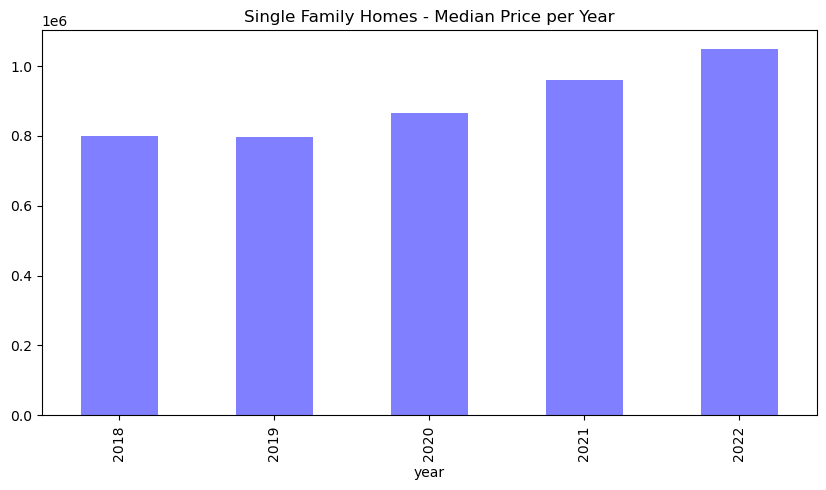

In [19]:
# seattle data - group by year column and calculate median price per for each year

sf_median_price_year = seattle_sf_df.groupby('year')['sale_price'].median()

# plot median price per year
sf_median_price_year.plot(kind='bar', figsize=(10,5), color='blue', alpha=0.5, align="center", title="Single Family Homes - Median Price per Year")

In [20]:
sf_median_price_year

year
2018     800000.0
2019     795725.0
2020     865000.0
2021     960000.0
2022    1050000.0
Name: sale_price, dtype: float64

<Axes: title={'center': 'Single Family Homes - Sales per Year'}, xlabel='year'>

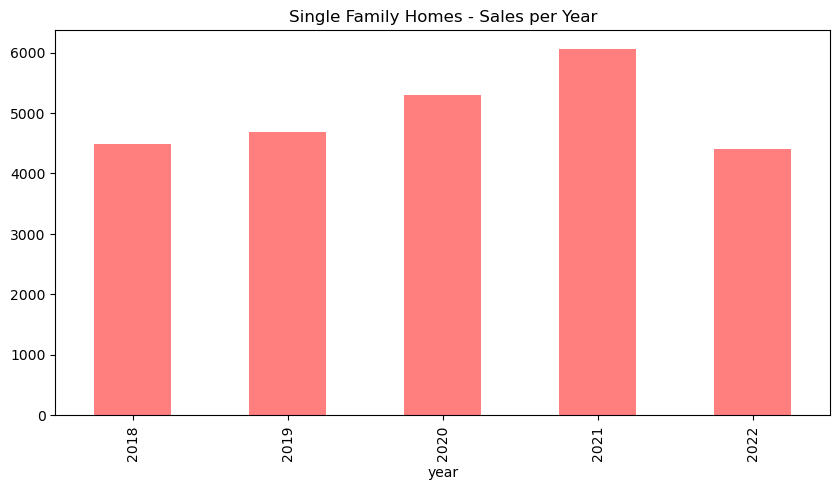

In [21]:
# seattle data - group by year column and count each sale

sf_sales_count_year = seattle_sf_df.groupby('year')['sale_price'].count()

# plot median price per year
sf_sales_count_year.plot(kind='bar', figsize=(10,5), color='red', alpha=0.5, align="center", title="Single Family Homes - Sales per Year")

In [22]:
# filter out just 2018 - 2022
years = [2018, 2019, 2020, 2021, 2022]

seattle_18_22_df = seattle_sf_df.loc[seattle_sf_df['year'].isin(years)]

# reset the index for 18' - 22'
seatle_18_22_df = seattle_18_22_df.reset_index(drop=True, inplace=True)

#write to csv file
seattle_18_22_df = seattle_18_22_df.to_csv('seattle_18_22.csv', index=True)

In [23]:
sf_sales_count_year

year
2018    4481
2019    4686
2020    5293
2021    6067
2022    4411
Name: sale_price, dtype: int64

In [65]:
# read in excel to dataframe
df_test = pd.read_excel('Resources\kingcounty\seattle_test_data.xlsx')
df_test.head()

,sale_date,sale_price,latitude,longitude,city,zoning,land_val,imp_val,year_built,sqft_lot,...,noise_traffic,view_rainier,view_olympics,view_cascades,view_territorial,view_skyline,view_sound,view_lakewash,view_otherwater,year
0,2018-01-02,665000,47.559358,-122.317370,SEATTLE,SF 5000,41000,122000,1920,2525,...,0,0,0,0,0,0,0,0,0,2018
1,2018-01-09,499000,47.524993,-122.316475,SEATTLE,SF 5000,29000,55000,1907,6000,...,0,0,0,0,0,0,0,0,0,2018
2,2018-02-14,675000,47.624203,-122.300762,SEATTLE,SF 5000,97000,132000,1908,5286,...,0,0,0,2,0,0,0,0,0,2018
3,2018-02-13,1150000,47.721276,-122.335857,SEATTLE,SF 7200,440000,221000,1920,47916,...,2,0,0,0,0,0,0,0,4,2018
4,2018-02-14,705000,47.666210,-122.324618,SEATTLE,SF 5000,81000,72000,1918,3825,...,0,0,0,0,0,0,0,0,0,2018


In [38]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   sale_date         4999 non-null   datetime64[ns]
 1   sale_price        4999 non-null   int64         
 2   latitude          4999 non-null   float64       
 3   longitude         4999 non-null   float64       
 4   city              4999 non-null   object        
 5   zoning            4999 non-null   object        
 6   land_val          4999 non-null   int64         
 7   imp_val           4999 non-null   int64         
 8   year_built        4999 non-null   int64         
 9   sqft_lot          4999 non-null   int64         
 10  sqft              4999 non-null   int64         
 11  grade             4999 non-null   int64         
 12  fbsmt_grade       4999 non-null   int64         
 13  home_condition    4999 non-null   int64         
 14  stories           4999 n

In [78]:
def get_zipcode(df_test, geolocator, latitude, longitude):
    location = geolocator.reverse((df_test['latitude'], df_test['longitude']))
    return location.raw['address']['postcode']

geolocator = geopy.Nominatim(user_agent="4321")

zipcodes = df_test.apply(get_zipcode, axis=1, geolocator=geolocator, latitude='Lat', longitude='Lon')



In [79]:
# add list to dataframe
df_test['zipcode'] = zipcodes

In [81]:
# add zipcodes to dataframe
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   sale_date         4999 non-null   datetime64[ns]
 1   sale_price        4999 non-null   int64         
 2   latitude          4999 non-null   float64       
 3   longitude         4999 non-null   float64       
 4   city              4999 non-null   object        
 5   zoning            4999 non-null   object        
 6   land_val          4999 non-null   int64         
 7   imp_val           4999 non-null   int64         
 8   year_built        4999 non-null   int64         
 9   sqft_lot          4999 non-null   int64         
 10  sqft              4999 non-null   int64         
 11  grade             4999 non-null   int64         
 12  fbsmt_grade       4999 non-null   int64         
 13  home_condition    4999 non-null   int64         
 14  stories           4999 n

In [77]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   sale_date         4999 non-null   datetime64[ns]
 1   sale_price        4999 non-null   int64         
 2   latitude          4999 non-null   float64       
 3   longitude         4999 non-null   float64       
 4   city              4999 non-null   object        
 5   zoning            4999 non-null   object        
 6   land_val          4999 non-null   int64         
 7   imp_val           4999 non-null   int64         
 8   year_built        4999 non-null   int64         
 9   sqft_lot          4999 non-null   int64         
 10  sqft              4999 non-null   int64         
 11  grade             4999 non-null   int64         
 12  fbsmt_grade       4999 non-null   int64         
 13  home_condition    4999 non-null   int64         
 14  stories           4999 n

In [48]:
df_test_2 = pd.read_excel('Resources\kingcounty\seattle_test_data_2.xlsx')
df_test_2.head()

,sale_date,sale_price,latitude,longitude,city,zoning,land_val,imp_val,year_built,sqft_lot,...,noise_traffic,view_rainier,view_olympics,view_cascades,view_territorial,view_skyline,view_sound,view_lakewash,view_otherwater,year
0,2018-08-30,1150000,47.638462,-122.303697,SEATTLE,NR3,507000,762000,1922,3157,...,0,0,0,0,0,0,0,0,0,2018
1,2018-09-04,700000,47.570459,-122.407706,SEATTLE,NR2,724000,135000,1952,4700,...,0,0,4,0,4,0,4,0,0,2018
2,2018-09-04,806000,47.703777,-122.279231,SEATTLE,NR2,423000,511000,1984,4800,...,0,0,0,0,0,0,0,0,0,2018
3,2018-08-28,725000,47.534805,-122.382987,SEATTLE,NR3,341000,630000,1957,6120,...,0,0,0,0,0,0,0,0,0,2018
4,2018-08-28,907000,47.588950,-122.387976,SEATTLE,NR3,460000,608000,1924,5750,...,0,0,0,0,0,0,0,0,0,2018


In [49]:
def get_zipcode(df_test_2, geolocator, latitude, longitude):
    location = geolocator.reverse((df_test_2['latitude'], df_test_2['longitude']))
    return location.raw['address']['postcode']

geolocator = geopy.Nominatim(user_agent="4321")

zipcodes = df_test_2.apply(get_zipcode, axis=1, geolocator=geolocator, latitude='Lat', longitude='Lon')



In [51]:
df_test_2['zipcode'] = zipcodes
df_test_2.tail()

,sale_date,sale_price,latitude,longitude,city,zoning,land_val,imp_val,year_built,sqft_lot,...,view_rainier,view_olympics,view_cascades,view_territorial,view_skyline,view_sound,view_lakewash,view_otherwater,year,zipcode
4996,2020-03-06,1060000,47.686434,-122.346564,SEATTLE,NR3,641000,672000,1909,4500,...,0,0,0,0,0,0,0,0,2020,98103
4997,2020-03-06,732000,47.699832,-122.360361,SEATTLE,NR3,405000,424000,1940,7087,...,0,0,0,0,0,0,0,0,2020,98117
4998,2020-02-27,787000,47.682829,-122.382496,SEATTLE,NR3,486000,364000,1909,3570,...,0,0,0,0,0,0,0,0,2020,98117
4999,2020-02-27,550000,47.549681,-122.356764,SEATTLE,NR3,304000,418000,1961,8475,...,0,0,0,0,0,0,0,0,2020,98106
5000,2020-03-05,1600000,47.581758,-122.391530,SEATTLE,NR3,444000,1112000,1914,5092,...,0,0,0,0,0,0,0,0,2020,98116


In [53]:
df_test_3 = pd.read_excel('Resources\kingcounty\seattle_test_data_3.xlsx')
df_test_3.head()

,sale_date,sale_price,latitude,longitude,city,zoning,land_val,imp_val,year_built,sqft_lot,...,noise_traffic,view_rainier,view_olympics,view_cascades,view_territorial,view_skyline,view_sound,view_lakewash,view_otherwater,year
0,2020-03-06,1495000,47.544750,-122.262282,SEATTLE,NR2,596000,963000,1963,10740,...,0,0,0,2,2,0,0,2,0,2020
1,2020-03-05,845036,47.538677,-122.388809,SEATTLE,NR3,387000,552000,1930,4250,...,0,0,0,0,3,0,1,0,0,2020
2,2020-03-03,860000,47.681825,-122.276828,SEATTLE,NR3,740000,191000,1944,6489,...,0,0,0,0,0,0,0,0,0,2020
3,2020-03-09,832500,47.550668,-122.304571,SEATTLE,NR3,278000,675000,1981,5073,...,0,0,0,0,0,0,0,0,0,2020
4,2020-03-06,705000,47.676897,-122.365748,SEATTLE,NR3,264000,512000,1918,2130,...,2,0,0,0,0,0,0,0,0,2020


In [54]:
def get_zipcode(df_test_3, geolocator, latitude, longitude):
    location = geolocator.reverse((df_test_3['latitude'], df_test_3['longitude']))
    return location.raw['address']['postcode']

geolocator = geopy.Nominatim(user_agent="4321")

zipcodes = df_test_3.apply(get_zipcode, axis=1, geolocator=geolocator, latitude='Lat', longitude='Lon')

In [55]:
df_test_3['zipcode'] = zipcodes
df_test_3.tail()

,sale_date,sale_price,latitude,longitude,city,zoning,land_val,imp_val,year_built,sqft_lot,...,view_rainier,view_olympics,view_cascades,view_territorial,view_skyline,view_sound,view_lakewash,view_otherwater,year,zipcode
4992,2021-04-27,650000,47.673310,-122.369273,SEATTLE,NR3,526000,132000,1906,5000,...,0,0,0,0,0,0,0,0,2021,98107
4993,2021-04-27,910000,47.616591,-122.294472,SEATTLE,NR3,575000,368000,1957,4800,...,0,0,0,0,0,0,0,0,2021,98122
4994,2021-04-26,996000,47.575996,-122.388422,SEATTLE,NR3,328000,520000,1925,4255,...,0,0,0,0,0,0,0,0,2021,98116
4995,2021-04-28,865000,47.712980,-122.283907,SEATTLE,NR2,438000,444000,1954,7200,...,0,0,0,0,0,0,0,0,2021,98125
4996,2021-05-05,1050000,47.560993,-122.391236,SEATTLE,NR3,440000,468000,1917,5850,...,0,0,0,2,0,1,0,0,2021,98116


In [56]:
df_test_4 = pd.read_excel('Resources\kingcounty\seattle_test_data_4.xlsx')
df_test_4.head()

,sale_date,sale_price,latitude,longitude,city,zoning,land_val,imp_val,year_built,sqft_lot,...,noise_traffic,view_rainier,view_olympics,view_cascades,view_territorial,view_skyline,view_sound,view_lakewash,view_otherwater,year
0,2021-04-30,657500,47.550543,-122.295191,SEATTLE,NR3,306000,407000,1953,6255,...,1,0,0,0,0,0,0,0,0,2021
1,2021-04-26,990000,47.511514,-122.253851,SEATTLE,NR3,254000,633000,1964,5876,...,0,0,0,0,2,0,0,2,0,2021
2,2021-04-29,1049000,47.638193,-122.389168,SEATTLE,NR3,801000,403000,1919,4000,...,0,0,0,0,2,2,0,0,0,2021
3,2021-04-29,1157000,47.663863,-122.326885,SEATTLE,NR3,613000,406000,1911,4080,...,0,0,0,0,0,0,0,0,0,2021
4,2021-05-04,521000,47.552851,-122.273938,SEATTLE,NR3,355000,321000,1918,7210,...,0,0,0,0,0,0,0,0,0,2021


In [57]:
def get_zipcode(df_test_4, geolocator, latitude, longitude):
    location = geolocator.reverse((df_test_4['latitude'], df_test_4['longitude']))
    return location.raw['address']['postcode']

geolocator = geopy.Nominatim(user_agent="4321")

zipcodes = df_test_4.apply(get_zipcode, axis=1, geolocator=geolocator, latitude='Lat', longitude='Lon')

In [58]:
df_test_4['zipcode'] = zipcodes
df_test_4.tail()

,sale_date,sale_price,latitude,longitude,city,zoning,land_val,imp_val,year_built,sqft_lot,...,view_rainier,view_olympics,view_cascades,view_territorial,view_skyline,view_sound,view_lakewash,view_otherwater,year,zipcode
4994,2022-05-25,975000,47.689569,-122.340068,SEATTLE,NR3,664000,390000,1928,5018,...,0,0,0,0,0,0,0,0,2022,98103
4995,2022-06-09,2000000,47.686735,-122.353719,SEATTLE,NR3,543000,928000,1913,6060,...,0,0,0,0,0,0,0,0,2022,98103
4996,2022-06-01,772500,47.513073,-122.382780,SEATTLE,NR3,274000,385000,1957,5280,...,0,0,0,0,0,0,0,0,2022,98146
4997,2022-06-06,2100000,47.695349,-122.382258,SEATTLE,NR2,899000,893000,1954,6942,...,0,3,0,3,0,2,0,0,2022,98117
4998,2022-06-10,1425000,47.643899,-122.356449,SEATTLE,NR3,688000,499000,1927,3200,...,0,0,0,0,0,0,0,0,2022,98109


In [59]:
df_test_5 = pd.read_excel('Resources\kingcounty\seattle_test_data_5.xlsx')
df_test_5.head()

,sale_date,sale_price,latitude,longitude,city,zoning,land_val,imp_val,year_built,sqft_lot,...,noise_traffic,view_rainier,view_olympics,view_cascades,view_territorial,view_skyline,view_sound,view_lakewash,view_otherwater,year
0,2022-06-10,1250000,47.668159,-122.335109,SEATTLE,NR3,613000,424000,1922,4013,...,0,0,0,0,0,0,0,0,0,2022
1,2022-06-06,1075000,47.564261,-122.283171,SEATTLE,NR3,232000,468000,1979,3000,...,1,0,0,0,0,0,0,0,0,2022
2,2022-06-12,594000,47.521559,-122.347631,SEATTLE,NR3,214000,290000,1950,4760,...,0,0,0,0,0,0,0,0,0,2022
3,2022-06-06,726000,47.540932,-122.350728,SEATTLE,NR2,315000,384000,1960,8750,...,0,0,0,0,0,0,0,0,0,2022
4,2022-06-10,1265000,47.684239,-122.356727,SEATTLE,NR3,521000,590000,1906,4429,...,0,0,0,0,0,0,0,0,0,2022


In [100]:
def get_zipcode(df_test_5, geolocator, latitude, longitude):
    location = geolocator.reverse((df_test_5['latitude'], df_test_5['longitude']))
    return location.raw['address']['postcode']

geolocator = geopy.Nominatim(user_agent="4321")

zipcodes_5 = df_test_5.apply(get_zipcode, axis=1, geolocator=geolocator, latitude='Lat', longitude='Lon')

In [102]:
# run this next
df_test_5['zipcode'] = zipcodes_5
df_test_5.tail()

,sale_date,sale_price,latitude,longitude,city,zoning,land_val,imp_val,year_built,sqft_lot,...,view_rainier,view_olympics,view_cascades,view_territorial,view_skyline,view_sound,view_lakewash,view_otherwater,year,zipcode
4937,2022-12-08,895000,47.689100,-122.332842,SEATTLE,NR3,440000,327000,1926,3000,...,0,0,0,0,0,0,0,0,2022,98103
4938,2022-12-05,1900000,47.595587,-122.291790,SEATTLE,NR3,790000,1432000,1924,5016,...,0,0,2,2,0,0,1,0,2022,98144
4939,2022-12-17,1750000,47.629275,-122.307670,SEATTLE,NR3,853000,727000,1908,4800,...,0,0,0,0,0,0,0,0,2022,98112
4940,2022-12-15,1250000,47.676524,-122.392174,SEATTLE,NR3,497000,532000,1928,3825,...,0,0,0,0,0,0,0,0,2022,98117
4941,2022-12-16,1268900,47.713828,-122.361862,SEATTLE,NR2,359000,637000,1951,7200,...,0,0,0,0,0,0,0,0,2022,98177


In [103]:
print(df_test_5.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4942 entries, 0 to 4941
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   sale_date         4942 non-null   datetime64[ns]
 1   sale_price        4942 non-null   int64         
 2   latitude          4942 non-null   float64       
 3   longitude         4942 non-null   float64       
 4   city              4942 non-null   object        
 5   zoning            4942 non-null   object        
 6   land_val          4942 non-null   int64         
 7   imp_val           4942 non-null   int64         
 8   year_built        4942 non-null   int64         
 9   sqft_lot          4942 non-null   int64         
 10  sqft              4942 non-null   int64         
 11  grade             4942 non-null   int64         
 12  fbsmt_grade       4942 non-null   int64         
 13  home_condition    4942 non-null   int64         
 14  stories           4942 n

In [84]:
# append df_test and df_test_2
df_test.append(df_test_2)



C:\Users\allan\AppData\Local\Temp\ipykernel_18600\1846396933.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test.append(df_test_2)


,sale_date,sale_price,latitude,longitude,city,zoning,land_val,imp_val,year_built,sqft_lot,...,view_rainier,view_olympics,view_cascades,view_territorial,view_skyline,view_sound,view_lakewash,view_otherwater,year,zipcode
0,2018-01-02,665000,47.559358,-122.317370,SEATTLE,SF 5000,41000,122000,1920,2525,...,0,0,0,0,0,0,0,0,2018,98108
1,2018-01-09,499000,47.524993,-122.316475,SEATTLE,SF 5000,29000,55000,1907,6000,...,0,0,0,0,0,0,0,0,2018,98108
2,2018-02-14,675000,47.624203,-122.300762,SEATTLE,SF 5000,97000,132000,1908,5286,...,0,0,2,0,0,0,0,0,2018,98112
3,2018-02-13,1150000,47.721276,-122.335857,SEATTLE,SF 7200,440000,221000,1920,47916,...,0,0,0,0,0,0,0,4,2018,98133
4,2018-02-14,705000,47.666210,-122.324618,SEATTLE,SF 5000,81000,72000,1918,3825,...,0,0,0,0,0,0,0,0,2018,98105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,2020-03-06,1060000,47.686434,-122.346564,SEATTLE,NR3,641000,672000,1909,4500,...,0,0,0,0,0,0,0,0,2020,98103
4997,2020-03-06,732000,47.699832,-122.360361,SEATTLE,NR3,405000,424000,1940,7087,...,0,0,0,0,0,0,0,0,2020,98117
4998,2020-02-27,787000,47.682829,-122.382496,SEATTLE,NR3,486000,364000,1909,3570,...,0,0,0,0,0,0,0,0,2020,98117
4999,2020-02-27,550000,47.549681,-122.356764,SEATTLE,NR3,304000,418000,1961,8475,...,0,0,0,0,0,0,0,0,2020,98106


In [104]:
df_zip = pd.concat([df_test, df_test_2, df_test_3, df_test_4, df_test_5])
df_zip.head()

,sale_date,sale_price,latitude,longitude,city,zoning,land_val,imp_val,year_built,sqft_lot,...,view_rainier,view_olympics,view_cascades,view_territorial,view_skyline,view_sound,view_lakewash,view_otherwater,year,zipcode
0,2018-01-02,665000,47.559358,-122.317370,SEATTLE,SF 5000,41000,122000,1920,2525,...,0,0,0,0,0,0,0,0,2018,98108
1,2018-01-09,499000,47.524993,-122.316475,SEATTLE,SF 5000,29000,55000,1907,6000,...,0,0,0,0,0,0,0,0,2018,98108
2,2018-02-14,675000,47.624203,-122.300762,SEATTLE,SF 5000,97000,132000,1908,5286,...,0,0,2,0,0,0,0,0,2018,98112
3,2018-02-13,1150000,47.721276,-122.335857,SEATTLE,SF 7200,440000,221000,1920,47916,...,0,0,0,0,0,0,0,4,2018,98133
4,2018-02-14,705000,47.666210,-122.324618,SEATTLE,SF 5000,81000,72000,1918,3825,...,0,0,0,0,0,0,0,0,2018,98105


In [105]:
df_zip.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24938 entries, 0 to 4941
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   sale_date         24938 non-null  datetime64[ns]
 1   sale_price        24938 non-null  int64         
 2   latitude          24938 non-null  float64       
 3   longitude         24938 non-null  float64       
 4   city              24938 non-null  object        
 5   zoning            24938 non-null  object        
 6   land_val          24938 non-null  int64         
 7   imp_val           24938 non-null  int64         
 8   year_built        24938 non-null  int64         
 9   sqft_lot          24938 non-null  int64         
 10  sqft              24938 non-null  int64         
 11  grade             24938 non-null  int64         
 12  fbsmt_grade       24938 non-null  int64         
 13  home_condition    24938 non-null  int64         
 14  stories           24938

In [106]:
# write df_zip to csv
df_zip.to_csv('df_zip.csv', index=False)

In [108]:
# convert zipcode from string to int
df_zip['zipcode'] = df_zip['zipcode'].astype(int)

In [109]:
df_zip.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24938 entries, 0 to 4941
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   sale_date         24938 non-null  datetime64[ns]
 1   sale_price        24938 non-null  int64         
 2   latitude          24938 non-null  float64       
 3   longitude         24938 non-null  float64       
 4   city              24938 non-null  object        
 5   zoning            24938 non-null  object        
 6   land_val          24938 non-null  int64         
 7   imp_val           24938 non-null  int64         
 8   year_built        24938 non-null  int64         
 9   sqft_lot          24938 non-null  int64         
 10  sqft              24938 non-null  int64         
 11  grade             24938 non-null  int64         
 12  fbsmt_grade       24938 non-null  int64         
 13  home_condition    24938 non-null  int64         
 14  stories           24938

In [110]:
df_zip.to_csv('df_zip.csv', index=False)